In [1]:
from classy import Class
#%matplotlib inline
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ["OMP_NUM_THREADS"] = "4" # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = "8" # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = "6" # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "4" # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "6" # export NUMEXPR_NUM_THREADS=6

In [2]:
import swyft

In [3]:
import yaml

In [10]:
'''simulator'''
lmax=2500
fsky=0.6
#ell=np.array([2,10,50,100,200,300,400,500])
ell=np.array([l for l in range(0,lmax+1)])
#ell=np.array([l for l in range(2,lmax+1)])
ells=ell*(ell+1)/(2*np.pi)

sigCV=np.sqrt(2/((2+ell)*fsky))
def simulator(v,noCV=False,sigma=0.1): 
    omega_b, omega_cdm, theta, lnAs,n_s,tau_reio=v[0],v[1],v[2],v[3],v[4],v[5]
    params = {
        'output': 'tCl pCl lCl',
        'l_max_scalars': lmax,
        'lensing': 'yes',
        'omega_b': omega_b,
        'omega_cdm': omega_cdm,
        '100*theta_s': theta,
        'ln10^{10}A_s': lnAs,
        'n_s': n_s,
        'tau_reio': tau_reio
    }

    # Create an instance of the CLASS wrapper
    cosmo = Class()

    # Set the parameters to the cosmological code
    cosmo.set(params)

    # Run the whole code. Depending on your output, it will call the
    # CLASS modules more or less fast. For instance, without any
    # output asked, CLASS will only compute background quantities,
    # thus running almost instantaneously.
    # This is equivalent to the beginning of the `main` routine of CLASS,
    # with all the struct_init() methods called.
    cosmo.compute()

    # Access the lensed cl until l=2000
    cls = cosmo.lensed_cl(lmax)
    T=cosmo.T_cmb()
    cosmo.struct_cleanup()
    #print(cls['tt'].shape)
    return dict(TT=cls['tt'][ell]*(T*1.e6)**2, TE=cls['te'][ell]*(T*1.e6)**2,\
        EE=cls['ee'][ell]*(T*1.e6)**2)#*ells



#noise from cosmic variance and fake_planck_realistic file
#another method: add beam/window with sig= w^-ell exp(ell^2 sigma^2)*sigCV. look up w and sigma for Planck
#def noise(obs, params=None, sigma=1.0):

In [5]:
par={'omega_b': 0.0224,
    'omega_cdm': 0.120,
    '100*theta_s': 1.0411,
    'ln10^{10}A_s': 3.0753,
    'n_s':0.965,
    'tau_reio': 0.054,
    }
pl=list(par.values())

In [6]:
obs=simulator(pl)

In [7]:
%load_ext autoreload
%autoreload 2
from planck_2020_hillipop import TT

In [8]:
HP=TT()

*WARNING*: Likelihood class '_base_classes._InstallableLikelihood' has been renamed to 'base_classes.InstallableLikelihood' (no leading underscores!). Please use the new name, since the old one will be deprecated in the near future


In [9]:
HP._invkll.shape

(10816, 10816)

In [10]:
HP._get_matrix_size()

10816

In [11]:
HP._is_mode

{'TT': True, 'TE': False, 'EE': False, 'ET': False}

In [11]:
obs.update({'PP': np.zeros(2501)})

In [12]:
dlth=np.array([obs['TT']*ells, obs['EE']*ells, obs['PP'], obs['TE']*ells])

In [13]:
obs

{'TT': array([0.00000000e+00, 0.00000000e+00, 1.11112169e+03, ...,
        8.18042916e-05, 8.14966495e-05, 8.11909259e-05]),
 'TE': array([ 0.00000000e+00,  0.00000000e+00,  2.83782779e+00, ...,
        -3.05506979e-06, -3.05525416e-06, -3.05599293e-06]),
 'EE': array([0.00000000e+00, 0.00000000e+00, 3.35209656e-02, ...,
        2.98986689e-06, 2.99062914e-06, 2.99136196e-06]),
 'PP': array([0., 0., 0., ..., 0., 0., 0.])}

In [14]:
import yaml

In [15]:
with open('/var/scratch/aecole/hillipop/planck_2020_hillipop/params_EE.yaml') as f:
    EEp=yaml.load(f)
with open('/var/scratch/aecole/hillipop/planck_2020_hillipop/params_TE.yaml') as f:
    TEp=yaml.load(f)
with open('/var/scratch/aecole/hillipop/planck_2020_hillipop/params_TT.yaml') as f:
    TTp=yaml.load(f)
with open('/var/scratch/aecole/hillipop/planck_2020_hillipop/params_calib.yaml') as f:
    CALp=yaml.load(f)

<ipython-input-15-5cdac179e20a>:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  EEp=yaml.load(f)
<ipython-input-15-5cdac179e20a>:4: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  TEp=yaml.load(f)
<ipython-input-15-5cdac179e20a>:6: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  TTp=yaml.load(f)
<ipython-input-15-5cdac179e20a>:8: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  CALp=yaml.load(f)


In [16]:
params={}
for k in TTp.keys():
    if 'dist' in TTp[k]['prior']:
        params.update({k:TTp[k]['prior']['loc']})
    else:
        params.update({k:0.5*(TTp[k]['prior']['min']+TTp[k]['prior']['max'])})
for k in CALp.keys():
    if 'value' in CALp[k]:
        params.update({k:CALp[k]['value']})
    elif 'dist' in CALp[k]['prior']:
        params.update({k:CALp[k]['prior']['loc']})
    else:
        params.update({k:0.5*(CALp[k]['prior']['min']+CALp[k]['prior']['max'])})

In [17]:
HP.compute_chi2(np.array([obs['TT']*ells, obs['EE'], obs['PP'], obs['TE']]), **params)

16137.395993062519

In [18]:
dat0=HP.get_dat(dlth,**params)

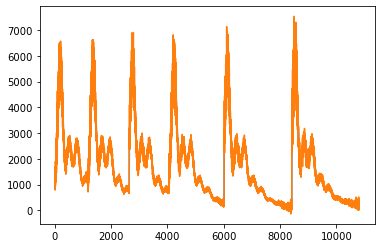

In [19]:
plt.plot(HP.get_vec(np.array([obs['TT']*ells, obs['EE'], obs['PP'], obs['TE']]),**params));
plt.plot(dat0)

In [20]:
dat0

array([1267.34073189,  861.23454599, 1526.15673596, ...,  138.70232399,
        183.72455619,  393.97489536])

In [21]:
icovmat=HP._invkll

In [22]:
ichol=np.linalg.cholesky(icovmat)

In [23]:
covmat=np.linalg.inv(icovmat)

In [24]:
chol=np.linalg.cholesky(covmat)

In [25]:
%%time
noisevecs=[np.dot(chol,np.random.randn(10816)) for i in range(10000)]

CPU times: user 4h 15min 1s, sys: 1h 58min 41s, total: 6h 13min 42s
Wall time: 11min 41s


In [ ]:
%%time
#noisevecs=[np.dot(chol, np.random.randn(10816)) for i in range(50000)]
#use cholesky to generate noisevecs since it's faster
#noisevecs=np.random.multivariate_normal(np.zeros(10816), covmat,size=50000)

ERROR! Session/line number was not unique in database. History logging moved to new session 309


non positive warning... due to numerical error? Should I worry? Is there a more stable way to sample?

In [23]:
#np.save('/var/scratch/aecole/hillipopNoise.npy',noisevecs)
#noisevecs = np.load('/var/scratch/aecole/hillipopNoise.npy')

In [25]:
'''simulator for HILLIPOP'''
lmax=2500
fsky=0.6
#ell=np.array([2,10,50,100,200,300,400,500])
ell=np.array([l for l in range(0,lmax+1)])
#ell=np.array([l for l in range(2,lmax+1)])
ells=ell*(ell+1)/(2*np.pi)

def simulator(v): 
    omega_b, omega_cdm, theta, lnAs,n_s,tau_reio=v[0],v[1],v[2],v[3],v[4],v[5]
    params = {
        'output': 'tCl pCl lCl',
        'YHe': 'BBN',
        'l_max_scalars': lmax,
        'lensing': 'yes',
        'omega_b': omega_b,
        'omega_cdm': omega_cdm,
        '100*theta_s': theta,
        'ln10^{10}A_s': lnAs,
        'n_s': n_s,
        'tau_reio': tau_reio
    }

    # Create an instance of the CLASS wrapper
    cosmo = Class()

    # Set the parameters to the cosmological code
    cosmo.set(params)

    # Run the whole code. Depending on your output, it will call the
    # CLASS modules more or less fast. For instance, without any
    # output asked, CLASS will only compute background quantities,
    # thus running almost instantaneously.
    # This is equivalent to the beginning of the `main` routine of CLASS,
    # with all the struct_init() methods called.
    cosmo.compute()

    # Access the lensed cl until l=2000
    cls = cosmo.lensed_cl(lmax)
    T=cosmo.T_cmb()
    cosmo.struct_cleanup()
    #print(cls['tt'].shape)
    TT=cls['tt'][ell]*ells*(T*1.e6)**2
    TE=cls['te'][ell]*ells*(T*1.e6)**2
    EE=cls['ee'][ell]*ells*(T*1.e6)**2
    PP=np.zeros(lmax+1)

    dlth=np.array([TT, EE, PP, TE])
    #now nuisance parameters
    nPar={'Aradio': v[6],
         'Adusty': v[7],
         'AdustTT': v[8],
         'Asz': v[9],
         'Acib': v[10],
         'Aksz': v[11],
         'Aszxcib': v[12],
         'A_planck': v[13],
         'cal100A': v[14],
         'cal100B': v[15],
         'cal143A': 0.0,
         'cal143B': v[16],
         'cal217A': v[17],
         'cal217B': v[18]}
    vec=HP.get_vec(dlth,**nPar)
    return dict(mu=vec)

def noise(obs, z=None):
    n=noisevecs[np.random.randint(0,10000)]
    #n=np.dot(chol,np.random.randn(10816))
    return dict(mu=obs['mu']+n)

In [29]:
out=simulator([0.0224, 0.12, 1.0411, 3.0753, 0.965, 0.054, 
           1.6,0.8, 1.0, 1.0,1.0, 5.0, 5.0,1.0,0,0,0,0,0])

In [19]:
valPaper=[0.02212,0.1209,1.04164, 3.058, 0.9649, 0.062]
sigPaper=[0.00021,0.0021, 0.00043, 0.022, 0.0058, 0.011]
#but for tau use the prior tau=0.058 \pm 0.012

In [20]:
valN1=np.array([1.6,0.8,1.0,1.0,1.0])
sigN1=np.array([0.2,0.2,0.2,0.2,0.2])

In [21]:
minN=np.array([0.0,0.0])
maxN=np.array([10.0,10.0])

In [22]:
valN2=np.array([1.0, 0.0, 0.0, 0.0, 0.0, 0.0])
sigN2=np.array([0.0025,0.002,0.002,0.002,0.002,0.002])

In [34]:
import scipy.stats

order is `omega_b, omega_cdm, theta, lnAs, n_s, tau_reio ` and then nuisance parameters

`'Aradio','Adusty','AdustTT','Asz','Acib','Aksz',
'Aszxcib','A_planck','cal100A','cal100B',
'cal143A'=FIXED,'cal143B','cal217A','cal217B'`

now to construct a prior transform: keep things uniform at $\pm 5\sigma$ for cosmological parameters and use either uniform or normal (depending on advisory from cobaya file) 

In [102]:
def uv(u):
    x=np.array(u)
    
    x[5:11]=np.max([x[5:11],0.00001*np.ones(6)],axis=0)
    x[5:11]=np.min([x[5:11],np.ones(6)-0.00001],axis=0)
    x[13:]=np.max([x[13:],0.00001*np.ones(6)],axis=0)
    x[13:]=np.min([x[13:],np.ones(6)-0.00001],axis=0)
    
    #offsets=np.array(valPaper)
    #scales=np.array([5*sigPaper[i] for i in range(len(sigPaper))])
    #x[:6]=2*(x[:6]-0.5)*scales+offsets
    
    offsets=np.array(valPaper[:-1])
    scales=np.array([5*sigPaper[i] for i in range(len(sigPaper[:-1]))])
    x[:5]=2*(x[:5]-0.5)*scales+offsets
    
    #Gaussian prior on tau
    t=scipy.stats.norm.ppf(x[5])
    Csqrt=0.01
    x[5]=Csqrt*t+0.058
    
    t=scipy.stats.norm.ppf(x[6:11])
    Csqrt=np.diag(sigN1)
    x[6:11]=np.dot(Csqrt,t)+valN1
    
    x[11]= u[11]
    x[11]*=10
    x[12]= u[12]
    x[12]*=10
    
    t=scipy.stats.norm.ppf(x[13:])
    Csqrt=np.diag(sigN2)
    x[13:]=np.dot(Csqrt,t)+valN2
    return x

In [103]:
uv(np.zeros(19))

array([ 0.02107   ,  0.1104    ,  1.03949   ,  2.948     ,  0.9359    ,
        0.01535109,  0.74702184, -0.05297816,  0.14702184,  0.14702184,
        0.14702184,  0.        ,  0.        ,  0.98933777, -0.00852978,
       -0.00852978, -0.00852978, -0.00852978, -0.00852978])

In [104]:
uv(np.ones(19))

array([2.31700000e-02, 1.31400000e-01, 1.04379000e+00, 3.16800000e+00,
       9.93900000e-01, 1.00648908e-01, 2.45297816e+00, 1.65297816e+00,
       1.85297816e+00, 1.85297816e+00, 1.85297816e+00, 1.00000000e+01,
       1.00000000e+01, 1.01066223e+00, 8.52978159e-03, 8.52978159e-03,
       8.52978159e-03, 8.52978159e-03, 8.52978159e-03])

In [105]:
uv(np.ones(19)*0.5)

array([0.02212, 0.1209 , 1.04164, 3.058  , 0.9649 , 0.058  , 1.6    ,
       0.8    , 1.     , 1.     , 1.     , 5.     , 5.     , 1.     ,
       0.     , 0.     , 0.     , 0.     , 0.     ])

In [39]:
prior=swyft.Prior.from_uv(uv, 19)

In [40]:
#sim=swyft.Simulator(simulator, sim_shapes={'TT':[2001], 'TE':[2001],'EE':[2001]})
sim=swyft.Simulator(simulator, sim_shapes={'mu':[10816]})

In [41]:
#store=swyft.DirectoryStore(list(par.keys()), simulator=sim, path='cacheTTTEEE.zarr')
store=swyft.DirectoryStore(['z'+str(i) for i in range(19)], simulator=sim, path='/var/scratch/aecole/hillipop.zarr')

In [42]:
from swyft.networks import OnlineNormalizationLayer
class Head10(swyft.Module):
    def __init__(self, obs_shapes):
        super().__init__(obs_shapes=obs_shapes)

        self.n_features = 40
        self.l = torch.nn.Linear(10816, 40)
        self.onl_f = OnlineNormalizationLayer(torch.Size([10816]))

    def forward(self, obs):
        x = obs['mu']
        x=self.onl_f(x)
        
        x=self.l(x)
        return x

In [43]:
partitions=[i for i in range(19)]

In [44]:
from dask.diagnostics import ProgressBar

In [45]:
import logging
logger = logging.getLogger()
logging.basicConfig(level=logging.DEBUG, format="%(message)s")
logger.setLevel(logging.DEBUG)

In [46]:
def SIMULATE(
        store,
        indices = None,
        fail_on_non_finite = True):
        """Run simulator sequentially on parameter store with missing corresponding simulations.
        Args:
            simulator: simulates an observation given a parameter input
            indices: list of sample indices for which a simulation is required
            fail_on_non_finite: if nan / inf in simulation, considered a failed simulation
        """
        if store._simulator is None:
            logging.warning("No simulator specified.  No simulations will run.")
            return

        store.lock()
        store._update()
        idx = store._get_indices_to_simulate(indices)
        store._set_simulation_status(idx, 1)
        store.unlock()

        if len(idx) == 0:
            logging.debug("No simulations required.")
            return
        else:
            z = [store.pars[i] for i in idx]
            res = RUN(store._simulator,z)
            x_all, validity = list(zip(*res))  # TODO: check other data formats

            for i, x, v in zip(idx, x_all, validity):
                if v == 0:
                    store._add_sim(i, x)
                else:
                    store._failed_sim(i)

        # some of the samples might be run by other processes - wait for these
        store.wait_for_simulations(indices)


In [47]:
import dask.bag as db
from dask.distributed import Client
def RUN(SIM, z, npartitions=16):
        """
        Run the simulator on the input parameters
        Args:
            z (list of dictionary): set of input parameters that need to
                                    be run by the simulator
            npartitions (int): number of partitions in which the input
                               parameters are divided for the parallelization
                               (default is about 100)
        """

        bag = db.from_sequence(z, npartitions=npartitions)
        bag = bag.map(swyft.store.simulator._run_one_sample, SIM.model, SIM.fail_on_non_finite)
        return bag.compute(scheduler=SIM.client or "processes")

In [90]:
#PAY ATTENTION TO SIMHOOK!
with ProgressBar():    
    dataset = swyft.Dataset(10000, prior, simhook = noise, store = store)
    #dataset.simulate()
    SIMULATE(store,dataset.indices)

DEBUG:root:Cache locked
DEBUG:root:Cache unlocked
DEBUG:root:No simulations required.


In [91]:
obs0={'mu': dat0}

In [92]:
post = swyft.Posteriors(dataset)

In [122]:
post.infer([5], device = 'cuda', head = Head10,
          train_args={'lr_schedule':[1e-3,3e-4,1e-4],'early_stopping_patience':2,
                     'max_epochs': 50})

DEBUG:root:Initializing swyft.Module with tag `Head10`
DEBUG:root:  args = `()`
DEBUG:root:  kwargs = `{'obs_shapes': {'mu': torch.Size([10816])}}`
DEBUG:root:Initializing swyft.Module with tag `DefaultTail`
DEBUG:root:  args = `(40, [(5,)])`
DEBUG:root:  kwargs = `{'n_tail_features': 2, 'p': 0.0, 'hidden_layers': [256, 256, 256], 'online_norm': True, 'param_transform': None, 'tail_features': False}`
DEBUG:root:Entering trainloop
DEBUG:root:  combinations = None
DEBUG:root:  batch_size = 32
DEBUG:root:  nworkers = 0
DEBUG:root:  max_epochs = 50
DEBUG:root:  early_stopping_patience = 2
DEBUG:root:  lr_schedule = [0.001, 0.0003, 0.0001]
DEBUG:root:  percent_validation = 0
DEBUG:root:lr: 0.001
DEBUG:root:validation loss = 1.387
DEBUG:root:validation loss = 1.376
DEBUG:root:validation loss = 1.385
DEBUG:root:validation loss = 1.386
DEBUG:root:lr: 0.0003
DEBUG:root:validation loss = 1.379
DEBUG:root:validation loss = 1.375
DEBUG:root:validation loss = 1.366
DEBUG:root:validation loss = 1.36

In [ ]:
samples=post.sample(50000,obs0)

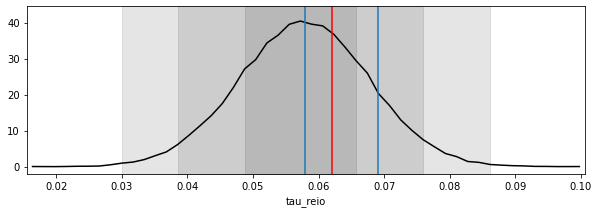

In [124]:
for i in [5]:
    swyft.plot1d(samples, [i],figsize=(10,3),bins=50, labels=[labels[i]])
    plt.axvline(valPaper[i],color='red')
    plt.axvline(0.058+sigPaper[i])
    plt.axvline(0.058)

In [118]:
par1=[0.02212, 0.1209 , 1.04164, 3.058  , 0.9649 , 0.03, 1.61, 0.78, 0.97, 1.0, 0.84, 0.0, 2.0,1.0, 0.002,
      0.002,-0.002, 0.002, 0.002]
obs1=simulator(par1)

In [119]:
samples1=post.sample(50000,obs1)

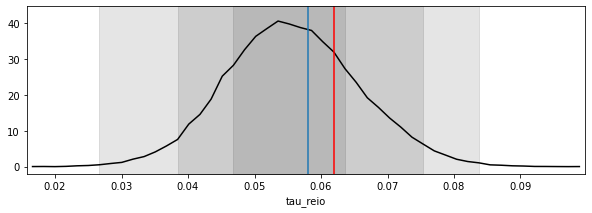

In [120]:
for i in [5]:
    swyft.plot1d(samples1, [i],figsize=(10,3),bins=50, labels=[labels[i]])
    plt.axvline(valPaper[i],color='red')
    plt.axvline(0.058)

Question: do I need to zoom in for the `obs0` data?

# TODO: try including prior on $\tau$ instead by outputting $\tau$ plus noise in simulator

TODO: compare `par1` more precisely to fit from the paper

figure out meaning of $A_{SZ\times CIB}$ to calibrate, check against paper

In [142]:
#parbf=[0.02212, 0.1209 , 1.04164, 3.058  , 0.9649 , 0.062, 1.61, 0.78, 0.97, 1.0, 0.84, 0.0, 2.0,1.0, 0.002,
#      0.002,-0.002, 0.002, 0.002]
parbf=[0.02212, 0.1209 , 1.04164, 3.058  , 0.9649 , 0.062, 1.61, 0.78, 0.97, 1.0, 0.84, 0.0, 2.0,1.0, 0.002,
      0.002,-0.002, 0.002, 0.002]

In [143]:
simBF=simulator(parbf)

In [144]:
np.dot(simBF['mu']-obs0['mu'],np.matmul(icovmat,simBF['mu']-obs0['mu']))

11768.674903980429

In [155]:
#parbf=[0.02212, 0.1209 , 1.04164, 3.058  , 0.9649 , 0.062, 1.61, 0.78, 0.97, 1.0, 0.84, 0.0, 2.0,1.0, 0.002,
#      0.002,-0.002, 0.002, 0.002]
parbf=[0.02250, 0.1209 , 1.04164, 3.058  , 0.9649 , 0.062, 1.61, 0.78, 0.97, 1.0, 0.84, 0.0, 2.0,1.0, 0.002,
      0.002,-0.002, 0.002, 0.002]

In [156]:
simBF=simulator(parbf)

In [157]:
np.dot(simBF['mu']-obs0['mu'],np.matmul(icovmat,simBF['mu']-obs0['mu']))

11780.225968492467

In [259]:
par1=[0.02212, 0.1209 , 1.04164, 3.058  , 0.9649 , 0.062, 1.61, 0.78, 0.97, 1.0, 0.84, 0.0, 2.0,1.0, 0.002,
      0.002,-0.002, 0.002, 0.002]
obs1=simulator(par1)

In [321]:
samples=post.sample(10000,obs0)

In [322]:
samples1=post.sample(10000,obs1)

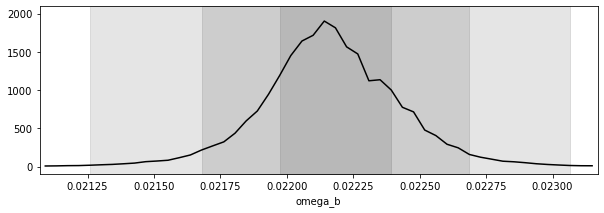

In [324]:
for i in range(1):
    swyft.plot1d(samples, [i],figsize=(10,3),bins=50, labels=[labels[i]])

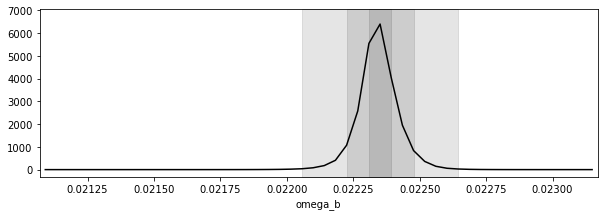

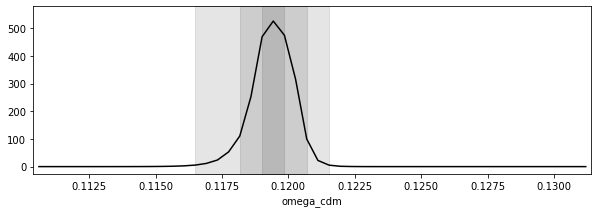

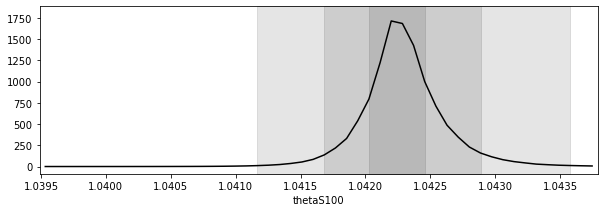

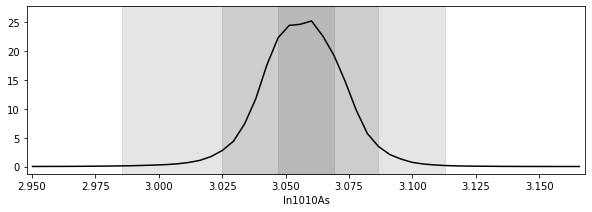

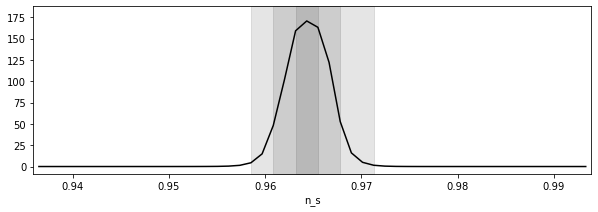

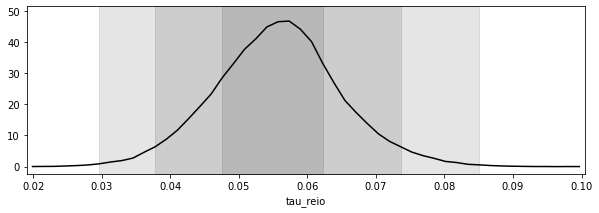

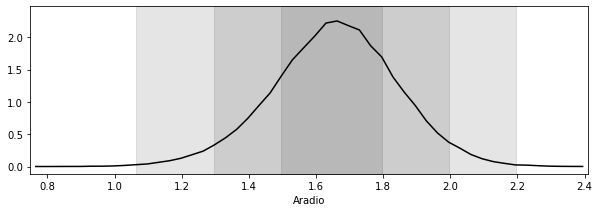

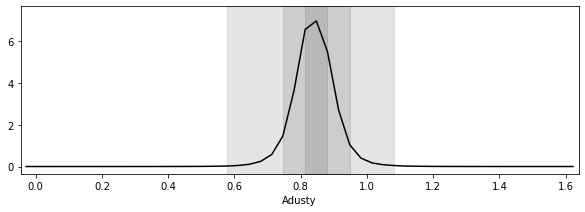

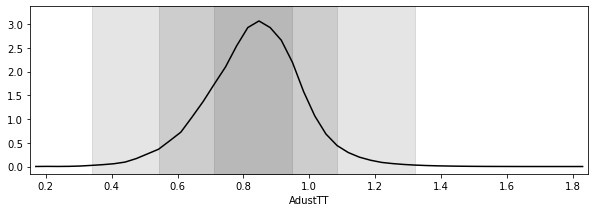

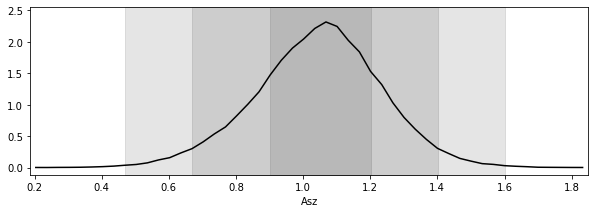

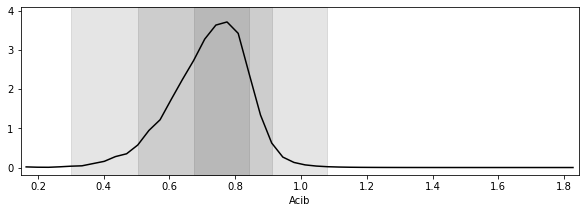

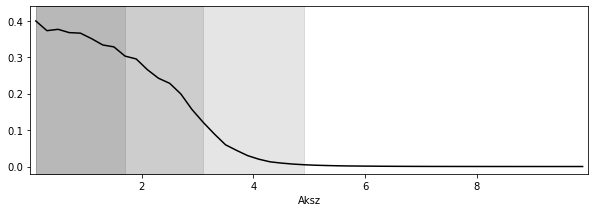

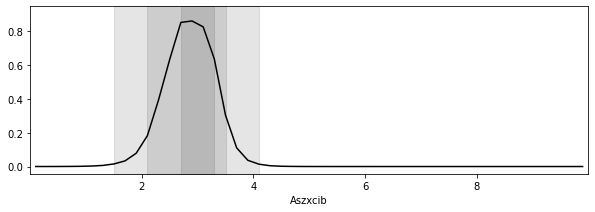

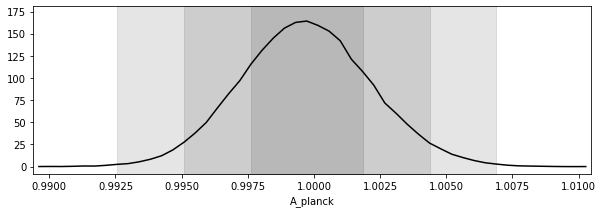

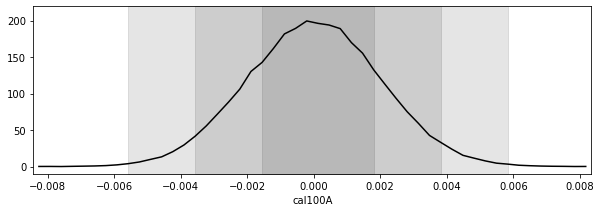

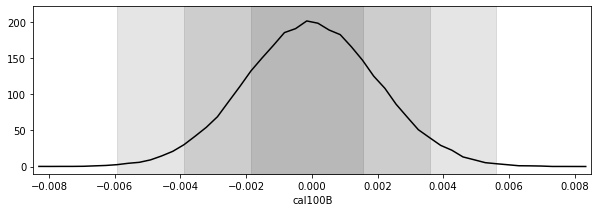

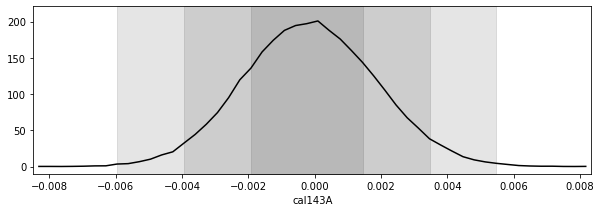

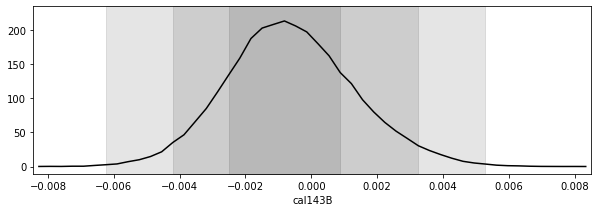

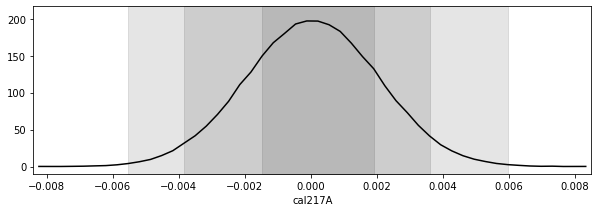

In [278]:
for i in range(19):
    swyft.plot1d(samples, [i],figsize=(10,3),bins=50, labels=[labels[i]])

0.001039245457517754
0.010286908031697739
0.0020199380775753895
0.10776513328995496
0.02840409720140713
0.010168850665092318


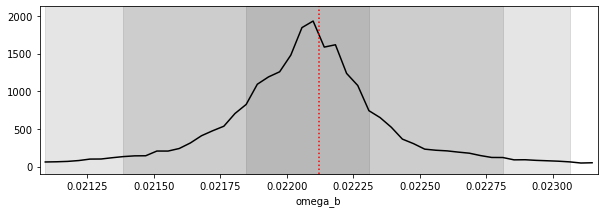

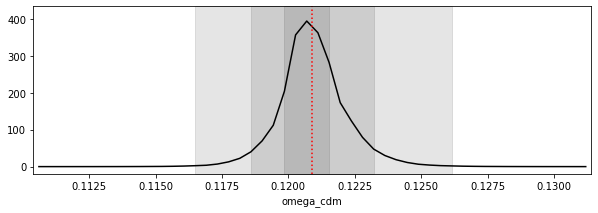

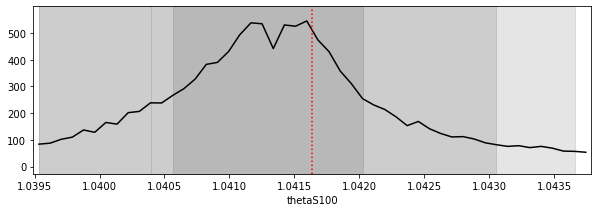

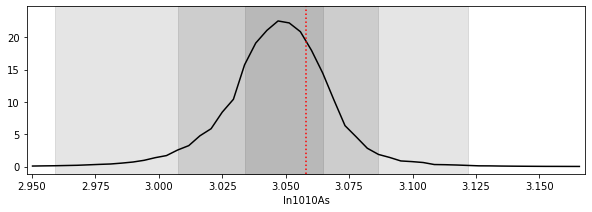

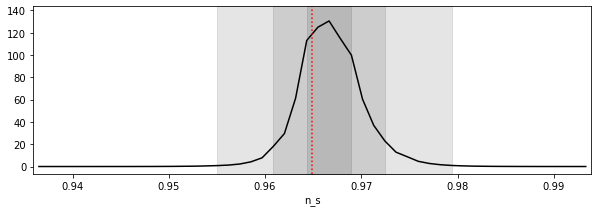

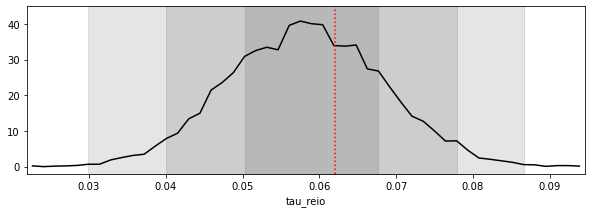

In [317]:
for i in range(6):
    swyft.plot1d(samples1, [i],figsize=(10,3),bins=50, truth=par1, labels=[labels[i]])
    weights_key = tuple([i])
    w = samples["weights"][tuple(weights_key)]
    x = samples1["params"][:, i]
    v, e = np.histogram(x, weights=w, bins=100, density=True)
    zm = (e[1:] + e[:-1]) / 2
    levels = sorted(swyft.utils.plot.get_contour_levels(v))
    sig1=(0.5*(e[np.where(v>levels[2])][-1]-e[np.where(v>levels[2])][0]))
    print(sig1)

0.0010394982865933999
0.010289781942651809
0.0019994648913096436
0.10889743333176938
0.02812927853549535
0.009333208979597524
0.1868943035957451
0.18594368091649405
0.18471969413423245
0.18596446648775766
0.18634413200635513
4.949935519492679
4.949943276663734
0.0023358239220602206
0.0018518709330517429
0.001870370732735117
0.0018585837520019833
0.0019450990068545972
0.0018484831039284862


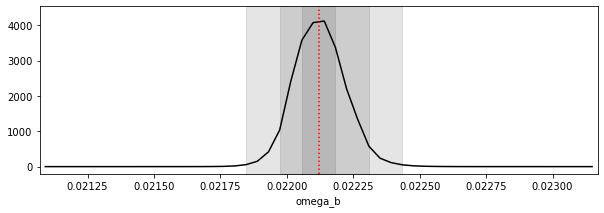

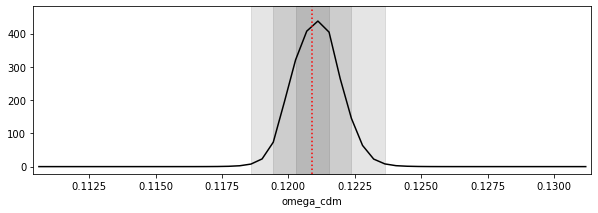

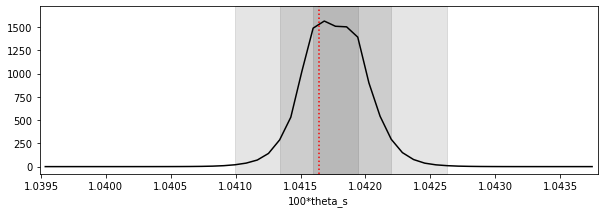

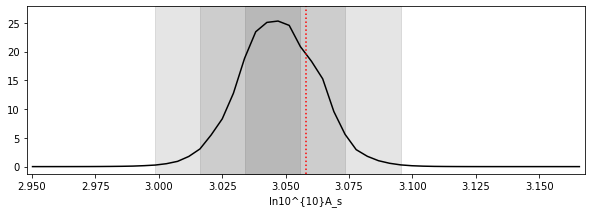

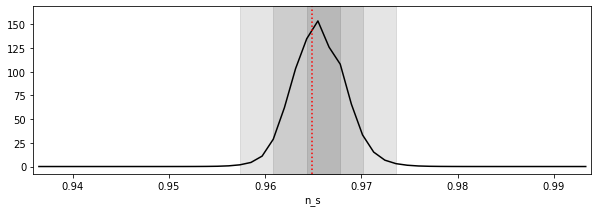

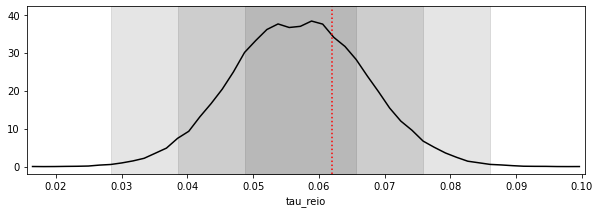

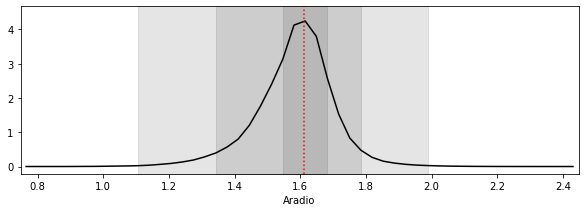

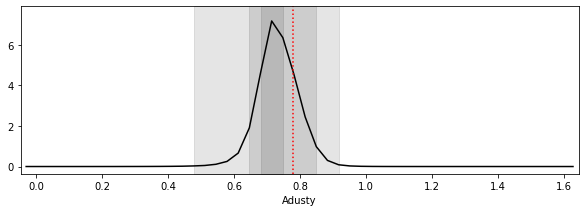

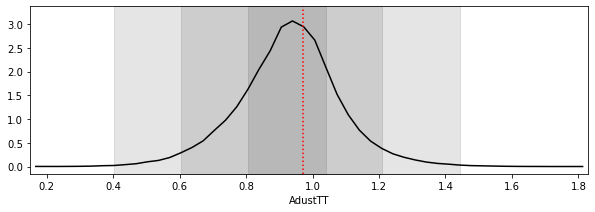

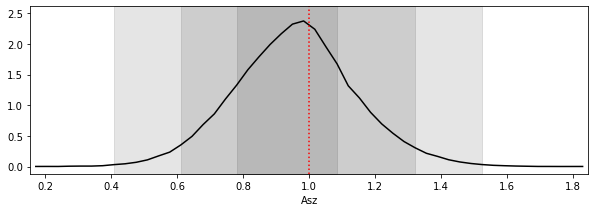

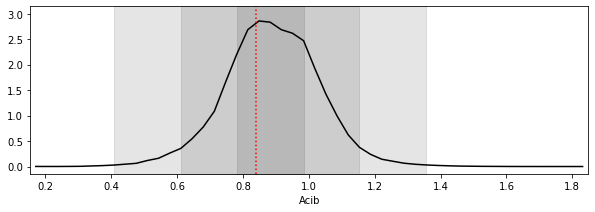

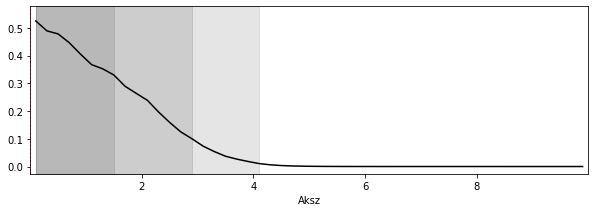

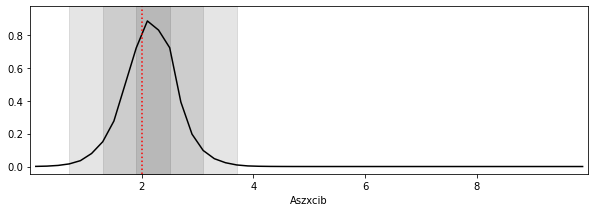

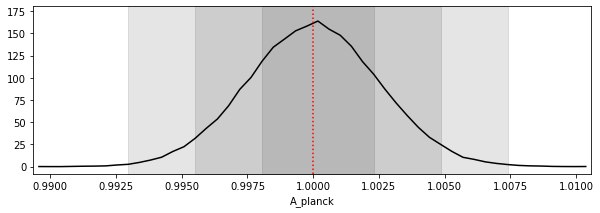

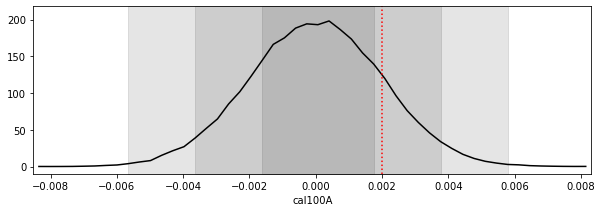

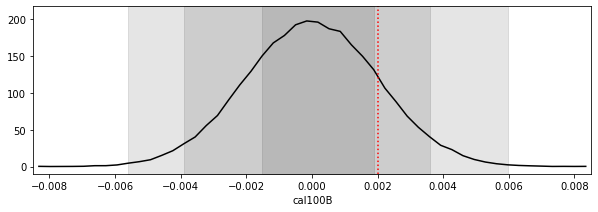

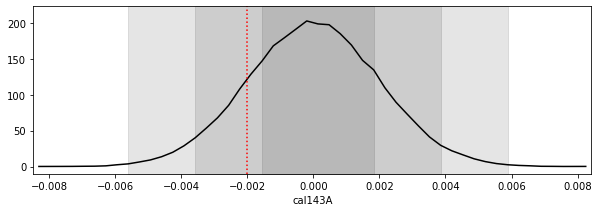

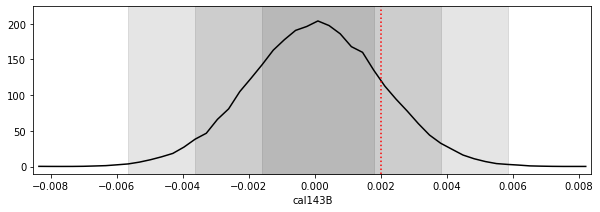

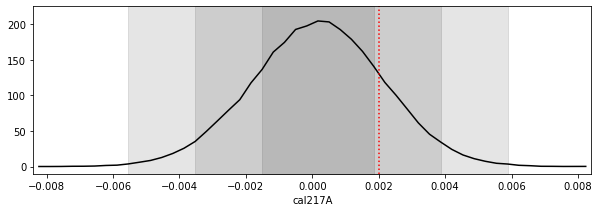

In [184]:
for i in range(19):
    swyft.plot1d(samples1, [i],figsize=(10,3),bins=50, truth=par1, labels=[labels[i]])
    weights_key = tuple([i])
    w = samples["weights"][tuple(weights_key)]
    x = samples1["params"][:, i]
    v, e = np.histogram(x, weights=w, bins=100, density=True)
    zm = (e[1:] + e[:-1]) / 2
    levels = sorted(swyft.utils.plot.get_contour_levels(v))
    sig1=(0.5*(e[np.where(v>levels[2])][-1]-e[np.where(v>levels[2])][0]))
    print(sig1)

In [174]:
levels

[2.8730207414975113, 27.533501684802246, 124.94090353005659]

In [183]:
0.5*(e[np.where(v>levels[2])][-1]-e[np.where(v>levels[2])][0])

0.0018484831039284862

In [ ]:
def getcontour(z, v, levels, ax=plt, linestyles=None, color=None, **kwargs):
    y0 = -0.05 * v.max()
    y1 = 1.1 * v.max()
    ax.fill_between(z, y0, y1, where=v > levels[0], color=color, alpha=0.1)
    ax.fill_between(z, y0, y1, where=v > levels[1], color=color, alpha=0.1)
    ax.fill_between(z, y0, y1, where=v > levels[2], color=color, alpha=0.1)

In [58]:
valPaper

[0.02212, 0.1209, 1.04164, 3.058, 0.9649, 0.062]

In [59]:
sigPaper

[0.00021, 0.0021, 0.00043, 0.022, 0.0058, 0.011]

In [60]:
np.array(valPaper)+np.array(sigPaper)

array([0.02233, 0.123  , 1.04207, 3.08   , 0.9707 , 0.073  ])

In [61]:
CALp

{'A_planck': {'prior': {'dist': 'norm', 'loc': 1, 'scale': 0.0025},
  'ref': {'dist': 'norm', 'loc': 1, 'scale': 0.002},
  'proposal': 0.0005,
  'latex': 'y_\\mathrm{cal}',
  'renames': 'calPlanck'},
 'cal100A': {'prior': {'dist': 'norm', 'loc': 0.0, 'scale': 0.002},
  'proposal': 0.001,
  'latex': 'cal_\\mathrm{100A}'},
 'cal100B': {'prior': {'dist': 'norm', 'loc': 0.0, 'scale': 0.002},
  'proposal': 0.001,
  'latex': 'cal_\\mathrm{100B}'},
 'cal143A': {'value': 0.0, 'latex': 'cal_\\mathrm{143A}'},
 'cal143B': {'prior': {'dist': 'norm', 'loc': 0.0, 'scale': 0.002},
  'proposal': 0.001,
  'latex': 'cal_\\mathrm{143B}'},
 'cal217A': {'prior': {'dist': 'norm', 'loc': 0.0, 'scale': 0.002},
  'proposal': 0.001,
  'latex': 'cal_\\mathrm{217A}'},
 'cal217B': {'prior': {'dist': 'norm', 'loc': 0.0, 'scale': 0.002},
  'proposal': 0.001,
  'latex': 'cal_\\mathrm{217B}'}}

In [62]:
TTp

{'Aradio': {'prior': {'dist': 'norm', 'loc': 1.6, 'scale': 0.2},
  'proposal': 0.1,
  'latex': 'A_\\mathrm{radio}^\\mathrm{PS}'},
 'Adusty': {'prior': {'dist': 'norm', 'loc': 0.8, 'scale': 0.2},
  'proposal': 0.1,
  'latex': 'A_\\mathrm{dust}^\\mathrm{PS}'},
 'AdustTT': {'prior': {'dist': 'norm', 'loc': 1.0, 'scale': 0.2},
  'proposal': 0.1,
  'latex': 'A_\\mathrm{dust}^\\mathrm{TT}'},
 'Asz': {'prior': {'dist': 'norm', 'loc': 1.0, 'scale': 0.2},
  'proposal': 0.1,
  'latex': 'A_\\mathrm{SZ}'},
 'Acib': {'prior': {'dist': 'norm', 'loc': 1.0, 'scale': 0.2},
  'proposal': 0.1,
  'latex': 'A_\\mathrm{CIB}'},
 'Aksz': {'prior': {'min': 0, 'max': 10},
  'ref': 0.6,
  'proposal': 1,
  'latex': 'A_\\mathrm{kSZ}'},
 'Aszxcib': {'prior': {'min': 0, 'max': 10},
  'ref': 1.0,
  'proposal': 1,
  'latex': 'A_\\mathrm{SZxCIB}'}}

In [63]:
uv(np.zeros(19))

array([ 2.10700000e-02,  1.10400000e-01,  1.03949000e+00,  2.94800000e+00,
        9.35900000e-01,  1.53510921e-02,  7.47021841e-01, -5.29781588e-02,
        1.47021841e-01,  1.47021841e-01,  1.47021841e-01, -1.00000000e+01,
       -1.00000000e+01,  9.89337773e-01, -8.52978159e-03, -8.52978159e-03,
       -8.52978159e-03, -8.52978159e-03, -8.52978159e-03])

In [101]:
labels=list(par.keys())+list(TTp.keys())+list(CALp.keys())

In [99]:
par.keys()

dict_keys(['omega_b', 'omega_cdm', '100*theta_s', 'ln10^{10}A_s', 'n_s', 'tau_reio'])

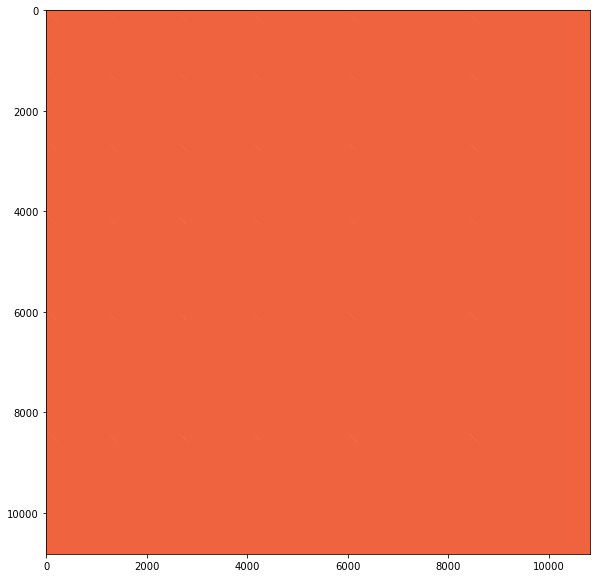

In [159]:
plt.figure(figsize=(10,10))
plt.imshow(covmat, cmap='RdYlBu')

In [160]:
covmat

array([[ 7.06708116e+04, -6.34891768e+01, -4.95123393e+03, ...,
        -3.57480593e-07, -3.98164584e-07, -4.46060265e-07],
       [-6.34891768e+01,  7.24789534e+04, -6.51326969e+01, ...,
        -3.53943568e-07, -4.07571367e-07, -4.40502039e-07],
       [-4.95123393e+03, -6.51326969e+01,  7.41628971e+04, ...,
        -3.66605589e-07, -4.02847644e-07, -4.48026076e-07],
       ...,
       [-3.57480593e-07, -3.53943568e-07, -3.66605588e-07, ...,
         1.18535898e+04, -2.63993345e+01, -2.72913684e+03],
       [-3.98164584e-07, -4.07571367e-07, -4.02847644e-07, ...,
        -2.63993345e+01,  1.19277028e+04, -2.65596620e+01],
       [-4.46060265e-07, -4.40502039e-07, -4.48026076e-07, ...,
        -2.72913684e+03, -2.65596620e+01,  1.19984728e+04]])

# check out least squares

In [185]:
from lmfit import minimize, Parameters, fit_report

In [187]:
labels

['omega_b',
 'omega_cdm',
 '100*theta_s',
 'ln10^{10}A_s',
 'n_s',
 'tau_reio',
 'Aradio',
 'Adusty',
 'AdustTT',
 'Asz',
 'Acib',
 'Aksz',
 'Aszxcib',
 'A_planck',
 'cal100A',
 'cal100B',
 'cal143A',
 'cal143B',
 'cal217A',
 'cal217B']

In [188]:
uv(np.zeros(19))

array([ 0.02107   ,  0.1104    ,  1.03949   ,  2.948     ,  0.9359    ,
        0.01535109,  0.74702184, -0.05297816,  0.14702184,  0.14702184,
        0.14702184,  0.        ,  0.        ,  0.98933777, -0.00852978,
       -0.00852978, -0.00852978, -0.00852978, -0.00852978])

In [190]:
dat0

array([1267.34073189,  861.23454599, 1526.15673596, ...,  138.70232399,
        183.72455619,  393.97489536])

In [198]:
labels[3]='ln1010As'

In [199]:
labels

['omega_b',
 'omega_cdm',
 'thetaS100',
 'ln1010As',
 'n_s',
 'tau_reio',
 'Aradio',
 'Adusty',
 'AdustTT',
 'Asz',
 'Acib',
 'Aksz',
 'Aszxcib',
 'A_planck',
 'cal100A',
 'cal100B',
 'cal143A',
 'cal143B',
 'cal217A',
 'cal217B']

In [253]:
st="global "
st=0
def residual(params, data=dat0, inv=icovmat, st=st):
    parvals = list(params.valuesdict().values())

    temp = simulator(parvals)['mu']
    vec= (data-temp)*(np.matmul(inv, data-temp))
    print("step"+str(st)+": "+str(vec.sum()))
    st+=1
    return vec


params = Parameters()
for i in range(19):
    params.add(labels[i], value=uv(np.zeros(19)+0.5)[i] , min=uv(np.zeros(19))[i],max=uv(np.ones(19))[i])
params['Aksz'].set(value=0.0, vary=False)
params['Aszxcib'].set(value=0.0)
params['tau_reio'].set(value=0.062)
params['cal100A'].set(vary=False)
params['cal100B'].set(vary=False)
params['cal143A'].set(vary=False)
params['cal143B'].set(vary=False)
params['cal217A'].set(vary=False)

#out = minimize(residual, params)

In [247]:
residual(params)

step0: 11888.738081868552


array([13.28477817,  0.22424739, 33.55782565, ...,  1.20930926,
        0.51379088,  1.52793581])

In [254]:
out = minimize(residual, params, method='nelder')

step0: 11888.738081868552
step0: 11888.735104656185
step0: 11888.73669377018
step0: 11888.711452794556
step0: 11889.085219772443
step0: 11888.832517856197
step0: 11883.853311421984
step0: 11888.738081868552
step0: 11888.738081868545
step0: 11888.738081868545
step0: 11888.738081868556
step0: 11888.738081868541
step0: 11888.407909776124
step0: 11888.738081868552
step0: 11893.888319965392
step0: 11899.22103884961
step0: 11890.104464701859
step0: 11890.585404056103
step0: 11890.884151564736
step0: 11891.314383821535
step0: 11891.669137128507
step0: 11892.053773019099
step0: 11892.61219986662
step0: 11893.19318270107
step0: 11893.813066732697
step0: 11894.566512238494
step0: 11895.541859739562
step0: 11896.690551714579
step0: 11897.411888184157
step0: 11897.293799273448
step0: 11898.147909597126
step0: 11899.054268284493
step0: 11899.954254087508
step0: 11904.465400114821
step0: 11901.583145080143
step0: 11902.60605679331
step0: 11903.646508178696
step0: 11909.51503073774
step0: 11905.51279

step0: 11906.816066629657
step0: 11906.806963175673
step0: 11906.816690408315
step0: 11906.805162614442
step0: 11906.818266954284
step0: 11906.808378249569
step0: 11906.810077115144
step0: 11906.807444284143
step0: 11906.812249264047
step0: 11906.809840217398
step0: 11906.807172763212
step0: 11906.792397924586
step0: 11906.793791426202
step0: 11906.817888725058
step0: 11906.823591920078
step0: 11906.805161313136
step0: 11906.809036493043
step0: 11906.816247918458
step0: 11906.790551370315
step0: 11906.80523285039
step0: 11906.795542178885
step0: 11906.766007689675
step0: 11906.815151561179
step0: 11906.789937102094
step0: 11906.80949549852
step0: 11906.797270129915
step0: 11906.815129852577
step0: 11906.808230118306
step0: 11906.792952220198
step0: 11906.797316873079
step0: 11906.792864133306
step0: 11906.787418729717
step0: 11906.778571535926
step0: 11906.82190939325
step0: 11906.82323097931
step0: 11906.828371000676
step0: 11906.809654771916
step0: 11906.802717804712
step0: 11906.799

step0: 11906.79794500102
step0: 11906.810871695667
step0: 11906.801556342289
step0: 11906.801654455969
step0: 11906.821746834517
step0: 11906.823412824877
step0: 11906.813782703948
step0: 11906.80495216201
step0: 11906.814373877862
step0: 11906.802097471009
step0: 11906.807301782108
step0: 11906.808269300029
step0: 11906.804749052037
step0: 11906.81069710797
step0: 11906.792095403727
step0: 11906.807883327272
step0: 11906.808618947898
step0: 11906.798771491907
step0: 11906.81187673979
step0: 11906.796945383034
step0: 11906.799769209532
step0: 11906.804352367955
step0: 11906.811655056586
step0: 11906.815759348592
step0: 11906.800835414006
step0: 11906.803786196313
step0: 11906.789449541404
step0: 11906.797663340545
step0: 11906.81501283234
step0: 11906.801295324389
step0: 11906.803364336933
step0: 11906.792930644377
step0: 11906.82796664353
step0: 11906.814760914198
step0: 11906.816138976827
step0: 11906.806532681807
step0: 11906.803223990602
step0: 11906.822272557694
step0: 11906.78664

In [255]:
out

# an idea: use flat priors, include $\tau$ as extra feature (plus gaussian noise)

In [46]:
'''simulator for HILLIPOP'''
lmax=2500
fsky=0.6
#ell=np.array([2,10,50,100,200,300,400,500])
ell=np.array([l for l in range(0,lmax+1)])
#ell=np.array([l for l in range(2,lmax+1)])
ells=ell*(ell+1)/(2*np.pi)

def simulator(v): 
    omega_b, omega_cdm, theta, lnAs,n_s,tau_reio=v[0],v[1],v[2],v[3],v[4],v[5]
    A_s=np.exp(lnAs)/ 1.e10
    params = {
        'output': 'tCl pCl lCl',
        'l_max_scalars': lmax,
        'lensing': 'yes',
        'omega_b': omega_b,
        'omega_cdm': omega_cdm,
        '100*theta_s': theta,
        #'ln10^{10}A_s': lnAs,
        'A_s': A_s,
        'n_s': n_s,
        'tau_reio': tau_reio
    }

    # Create an instance of the CLASS wrapper
    cosmo = Class()

    # Set the parameters to the cosmological code
    cosmo.set(params)

    # Run the whole code. Depending on your output, it will call the
    # CLASS modules more or less fast. For instance, without any
    # output asked, CLASS will only compute background quantities,
    # thus running almost instantaneously.
    # This is equivalent to the beginning of the `main` routine of CLASS,
    # with all the struct_init() methods called.
    cosmo.compute()

    # Access the lensed cl until l=2000
    cls = cosmo.lensed_cl(lmax)
    T=cosmo.T_cmb()
    cosmo.struct_cleanup()
    #print(cls['tt'].shape)
    TT=cls['tt'][ell]*ells*(T*1.e6)**2
    TE=cls['te'][ell]*ells*(T*1.e6)**2
    EE=cls['ee'][ell]*ells*(T*1.e6)**2
    PP=np.zeros(lmax+1)

    dlth=np.array([TT, EE, PP, TE])
    #now nuisance parameters
    nPar={'Aradio': v[6],
         'Adusty': v[7],
         'AdustTT': v[8],
         'Asz': v[9],
         'Acib': v[10],
         'Aksz': v[11],
         'Aszxcib': v[12],
         'A_planck': v[13],
         'cal100A': v[14],
         'cal100B': v[15],
         'cal143A': 0.0,
         'cal143B': v[16],
         'cal217A': v[17],
         'cal217B': v[18]}
    vec=HP.get_vec(dlth,**nPar)
    return dict(mu=vec, tau=tau_reio, nParPrior=np.concatenate((v[6:11],v[13:])))

def noise(obs, z=None):
    n=noisevecs[np.random.randint(0,10000)]
    #n=np.dot(chol,np.random.randn(10816))
    return dict(mu=obs['mu']+n, tau=obs['tau']+np.random.randn()*0.012, nParPrior=obs['nParPrior']+
               np.random.randn(11)*np.concatenate([sigN1,sigN2]))

In [47]:
out=simulator([0.0224, 0.12, 1.0411, 3.0753, 0.965, 0.054, 
           1.6,0.8, 1.0, 1.0,1.0, 5.0, 5.0,1.0,0,0,0,0,0])

In [48]:
noise(out)

{'mu': array([ 874.45870939,  751.58477645, 1323.24546518, ...,  342.83582625,
         333.37111676,  350.93276638]),
 'tau': 0.05422729783484861,
 'nParPrior': array([ 1.63581182e+00,  9.94454424e-01,  1.19594602e+00,  1.10667874e+00,
         8.22431940e-01,  9.99320174e-01, -1.22955141e-03,  1.71954451e-03,
        -2.48216796e-03, -2.87353808e-04,  3.02420678e-03])}

In [49]:
valPaper=[0.02212,0.1209,1.04164, 3.058, 0.9649, 0.062]
sigPaper=[0.00021,0.0021, 0.00043, 0.022, 0.0058, 0.011]
#but for tau use the prior tau=0.058 \pm 0.012

In [50]:
valN1=np.array([1.6,0.8,1.0,1.0,1.0])
sigN1=np.array([0.2,0.2,0.2,0.2,0.2])

In [51]:
minN=np.array([0.0,0.0])
maxN=np.array([10.0,10.0])

In [52]:
valN2=np.array([1.0, 0.0, 0.0, 0.0, 0.0, 0.0])
sigN2=np.array([0.0025,0.002,0.002,0.002,0.002,0.002])

In [53]:
import scipy.stats

order is `omega_b, omega_cdm, theta, lnAs, n_s, tau_reio ` and then nuisance parameters

`'Aradio','Adusty','AdustTT','Asz','Acib','Aksz',
'Aszxcib','A_planck','cal100A','cal100B',
'cal143A'=FIXED,'cal143B','cal217A','cal217B'`

now to construct a prior transform: keep things uniform at $\pm 5\sigma$ for cosmological parameters and use either uniform or normal (depending on advisory from cobaya file) 

In [ ]:
# does prior have a hard time moving since fewer samples in new interesting region? Try using uniform prior 
# for all parameters
# also possible to incorporate trick of passing parameter value through simulator

In [54]:
def uv(u):
    x=np.array(u)
    
    x[5:11]=np.max([x[5:11],0.00001*np.ones(6)],axis=0)
    x[5:11]=np.min([x[5:11],np.ones(6)-0.00001],axis=0)
    x[13:]=np.max([x[13:],0.00001*np.ones(6)],axis=0)
    x[13:]=np.min([x[13:],np.ones(6)-0.00001],axis=0)
    
    offsets=np.array(valPaper)
    scales=np.array([5*sigPaper[i] for i in range(len(sigPaper))])
    x[:6]=2*(x[:6]-0.5)*scales+offsets
    
    #offsets=np.array(valPaper[:-1])
    #scales=np.array([5*sigPaper[i] for i in range(len(sigPaper[:-1]))])
    #x[:5]=2*(x[:5]-0.5)*scales+offsets
    
    #Gaussian prior on tau
    #t=scipy.stats.norm.ppf(x[5])
    #Csqrt=0.01
    #x[5]=Csqrt*t+0.058
    offsets=np.array(valN1)
    scales=np.array([5*sigN1[i] for i in range(len(sigN1))])
    x[6:11]=2*(x[6:11]-0.5)*scales+offsets
    
    #t=scipy.stats.norm.ppf(x[6:11])
    #Csqrt=np.diag(sigN1)
    #x[6:11]=np.dot(Csqrt,t)+valN1
    
    x[11]= u[11]
    x[11]*=10
    x[12]= u[12]
    x[12]*=10
    
    offsets=np.array(valN2)
    scales=np.array([5*sigN2[i] for i in range(len(sigN2))])
    x[13:]=2*(x[13:]-0.5)*scales+offsets
    
    #t=scipy.stats.norm.ppf(x[13:])
    #Csqrt=np.diag(sigN2)
    #x[13:]=np.dot(Csqrt,t)+valN2
    return x

In [55]:
uv(np.zeros(19))

array([ 2.1070000e-02,  1.1040000e-01,  1.0394900e+00,  2.9480000e+00,
        9.3590000e-01,  7.0011000e-03,  6.0002000e-01, -1.9998000e-01,
        2.0000000e-05,  2.0000000e-05,  2.0000000e-05,  0.0000000e+00,
        0.0000000e+00,  9.8750025e-01, -9.9998000e-03, -9.9998000e-03,
       -9.9998000e-03, -9.9998000e-03, -9.9998000e-03])

In [56]:
uv(np.ones(19))

array([2.31700000e-02, 1.31400000e-01, 1.04379000e+00, 3.16800000e+00,
       9.93900000e-01, 1.16998900e-01, 2.59998000e+00, 1.79998000e+00,
       1.99998000e+00, 1.99998000e+00, 1.99998000e+00, 1.00000000e+01,
       1.00000000e+01, 1.01249975e+00, 9.99980000e-03, 9.99980000e-03,
       9.99980000e-03, 9.99980000e-03, 9.99980000e-03])

In [57]:
uv(np.ones(19)*0.5)

array([0.02212, 0.1209 , 1.04164, 3.058  , 0.9649 , 0.062  , 1.6    ,
       0.8    , 1.     , 1.     , 1.     , 5.     , 5.     , 1.     ,
       0.     , 0.     , 0.     , 0.     , 0.     ])

In [58]:
prior=swyft.Prior.from_uv(uv, 19)

In [59]:
#sim=swyft.Simulator(simulator, sim_shapes={'TT':[2001], 'TE':[2001],'EE':[2001]})
sim=swyft.Simulator(simulator, sim_shapes={'mu':[10816], 'tau':[1], 'nParPrior': [11]})

In [60]:
#store=swyft.DirectoryStore(list(par.keys()), simulator=sim, path='cacheTTTEEE.zarr')
store=swyft.DirectoryStore(['z'+str(i) for i in range(19)], simulator=sim, path='/var/scratch/aecole/hillipopUniformSamp.zarr')

DEBUG:root:  params = ['z0', 'z1', 'z2', 'z3', 'z4', 'z5', 'z6', 'z7', 'z8', 'z9', 'z10', 'z11', 'z12', 'z13', 'z14', 'z15', 'z16', 'z17', 'z18']
INFO:root:Loading existing store.


In [76]:
from swyft.networks import OnlineNormalizationLayer
class HeadDown(swyft.Module):
    def __init__(self, obs_shapes):
        super().__init__(obs_shapes=obs_shapes)

        self.n_features = 11
        #self.l = torch.nn.Linear(1071, 10)#2499
        self.l = torch.nn.Linear(1081, 10)#2499
        self.onl_f = OnlineNormalizationLayer(torch.Size([10816]))
        #self.ap = torch.nn.AvgPool1d(7) #3
        self.ap = torch.nn.AvgPool1d(10)


    def forward(self, obs):
        x = obs['mu']
        t=obs['tau']
        x=self.onl_f(x)
        #print(x.shape)
        
        nbatch = len(x)
        x=x.unsqueeze(1)
        
        x=self.ap(x)
        #print(x.shape)
        x=self.l(x)
        x=x.view(nbatch, -1)
        
        return torch.cat((t,x),axis=1)

In [97]:
obs0={'mu': dat0, 'tau': np.array([0.058])}

In [78]:
y={'mu': torch.tensor(obs0['mu'],dtype=torch.float32).unsqueeze(0),
   'tau': torch.tensor(obs0['tau'], dtype=torch.float32).unsqueeze(0)}

In [79]:
HeadDown({"mu": torch.Size([10816]),"tau": torch.Size([1])})(y).shape

torch.Size([1, 11])

In [44]:
obs0={'mu': dat0, 'tau': np.array([0.058])}

{'mu': array([1105.53656355, 1122.13764084, 1139.06114564, ...,  264.69154434,
         264.53980073,  264.3937569 ]),
 'tau': 0.054}

In [81]:
from swyft.networks import OnlineNormalizationLayer
class HeadLinear(swyft.Module):
    def __init__(self, obs_shapes):
        super().__init__(obs_shapes=obs_shapes)

        self.n_features = 52
        self.l = torch.nn.Linear(10816, 40)
        self.onl_f = OnlineNormalizationLayer(torch.Size([10816]))
        self.onl_f2=OnlineNormalizationLayer(torch.Size([1]))

    def forward(self, obs):
        x = obs['mu']
        t = obs['tau']
        np = obs['nParPrior']
        x=self.onl_f(x)
        t=self.onl_f2(t)
        
        x=self.l(x)
        return torch.cat((t,np,x),axis=1)

DEBUG:root:Registering new swyft.Module with tag `HeadLinear`


In [82]:
partitions=[i for i in range(19)]

In [63]:
from dask.diagnostics import ProgressBar

In [64]:
import logging
logger = logging.getLogger()
logging.basicConfig(level=logging.DEBUG, format="%(message)s")
logger.setLevel(logging.DEBUG)

In [65]:
def SIMULATE(
        store,
        indices = None,
        fail_on_non_finite = True):
        """Run simulator sequentially on parameter store with missing corresponding simulations.
        Args:
            simulator: simulates an observation given a parameter input
            indices: list of sample indices for which a simulation is required
            fail_on_non_finite: if nan / inf in simulation, considered a failed simulation
        """
        if store._simulator is None:
            logging.warning("No simulator specified.  No simulations will run.")
            return

        store.lock()
        store._update()
        idx = store._get_indices_to_simulate(indices)
        store._set_simulation_status(idx, 1)
        store.unlock()

        if len(idx) == 0:
            logging.debug("No simulations required.")
            return
        else:
            z = [store.pars[i] for i in idx]
            res = RUN(store._simulator,z)
            x_all, validity = list(zip(*res))  # TODO: check other data formats

            for i, x, v in zip(idx, x_all, validity):
                if v == 0:
                    store._add_sim(i, x)
                else:
                    store._failed_sim(i)

        # some of the samples might be run by other processes - wait for these
        store.wait_for_simulations(indices)


In [66]:
import dask.bag as db
from dask.distributed import Client
def RUN(SIM, z, npartitions=16):
        """
        Run the simulator on the input parameters
        Args:
            z (list of dictionary): set of input parameters that need to
                                    be run by the simulator
            npartitions (int): number of partitions in which the input
                               parameters are divided for the parallelization
                               (default is about 100)
        """

        bag = db.from_sequence(z, npartitions=npartitions)
        bag = bag.map(swyft.store.simulator._run_one_sample, SIM.model, SIM.fail_on_non_finite)
        return bag.compute(scheduler=SIM.client or "processes")

In [45]:
#PAY ATTENTION TO SIMHOOK!
with ProgressBar():    
    dataset = swyft.Dataset(5000, prior, simhook = noise, store = store)
    #dataset.simulate()
    SIMULATE(store,dataset.indices)

DEBUG:root:Cache locked
DEBUG:root:Cache unlocked
DEBUG:root:No simulations required.


In [68]:
#include prior data in obs0
obs0={'mu': dat0, 'tau': np.array([0.058]), 'nParPrior': np.concatenate((valN1,valN2))}

In [77]:
post = swyft.Posteriors(dataset)

In [83]:
post.infer(partitions, device = 'cuda', head = HeadLinear,
          train_args={'lr_schedule':[1e-3,3e-4,1e-4],'early_stopping_patience':2,
                     'max_epochs': 50})

DEBUG:root:Initializing swyft.Module with tag `HeadLinear`
DEBUG:root:  args = `()`
DEBUG:root:  kwargs = `{'obs_shapes': {'mu': torch.Size([10816]), 'tau': torch.Size([1]), 'nParPrior': torch.Size([11])}}`
DEBUG:root:Initializing swyft.Module with tag `DefaultTail`
DEBUG:root:  args = `(52, [(0,), (1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,), (9,), (10,), (11,), (12,), (13,), (14,), (15,), (16,), (17,), (18,)])`
DEBUG:root:  kwargs = `{'n_tail_features': 2, 'p': 0.0, 'hidden_layers': [256, 256, 256], 'online_norm': True, 'param_transform': None, 'tail_features': False}`
DEBUG:root:Entering trainloop
DEBUG:root:  combinations = None
DEBUG:root:  batch_size = 32
DEBUG:root:  nworkers = 0
DEBUG:root:  max_epochs = 50
DEBUG:root:  early_stopping_patience = 2
DEBUG:root:  lr_schedule = [0.001, 0.0003, 0.0001]
DEBUG:root:  percent_validation = 0
DEBUG:root:lr: 0.001
DEBUG:root:validation loss = 25.71
DEBUG:root:validation loss = 23.84
DEBUG:root:validation loss = 22.02
DEBUG:root:validati

In [84]:
sampsSW=post.sample(50000,obs0)

In [85]:
samps=np.loadtxt('chains/mcmc.1.txt', usecols=(2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21))

In [73]:
from getdist import plots, MCSamples
import getdist

Removed no burn in
Removed no burn in
x0 = 0.02196\pm 0.00018 x0 = 0.02212\pm 0.00020
Removed no burn in
Removed no burn in
x1 = 0.1201\pm 0.0018 x1 = 0.1204\pm 0.0020
Removed no burn in
Removed no burn in
x2 = 1.04186^{+0.00033}_{-0.00041} x2 = 1.04172\pm 0.00042
Removed no burn in
Removed no burn in
x3 = 3.053\pm 0.025 x3 = 3.044\pm 0.015
Removed no burn in
Removed no burn in
x4 = 0.9592^{+0.0049}_{-0.0058} x4 = 0.9609\pm 0.0053
Removed no burn in
Removed no burn in
x5 = 0.057\pm 0.011 x5 = 0.0551\pm 0.0073
Removed no burn in
Removed no burn in
x6 = 1.55\pm 0.13 x6 = 0.9999\pm 0.0025
Removed no burn in
Removed no burn in
x7 = 0.747^{+0.095}_{-0.086} x7 = -0.0001\pm 0.0016
Removed no burn in
Removed no burn in
x8 = 0.75\pm 0.16 x8 = 0.0027\pm 0.0016


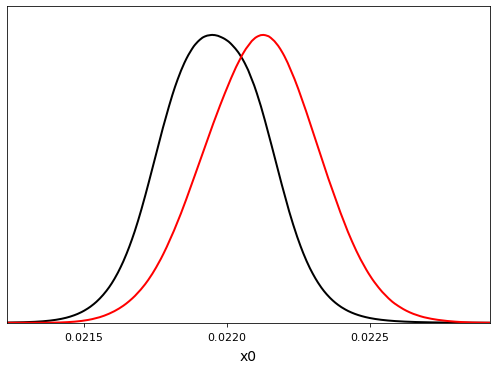

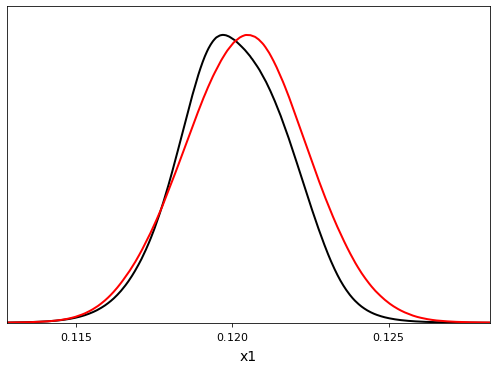

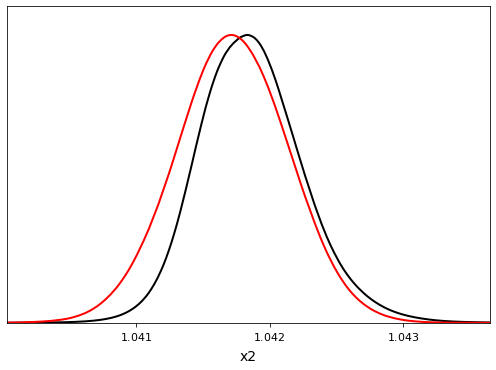

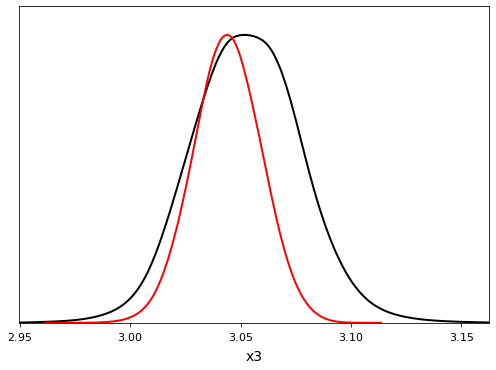

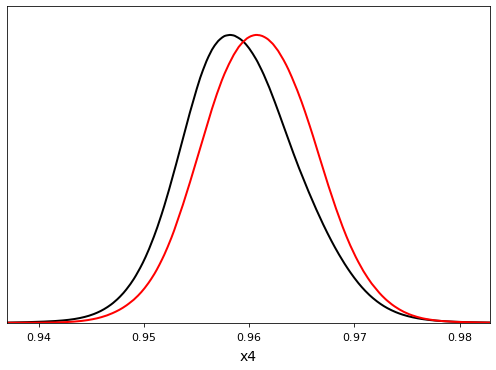

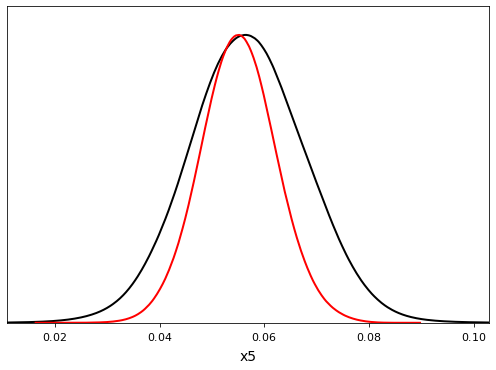

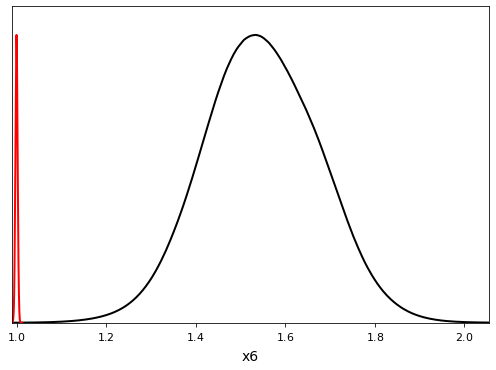

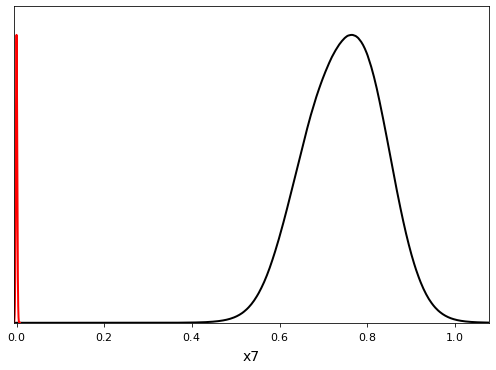

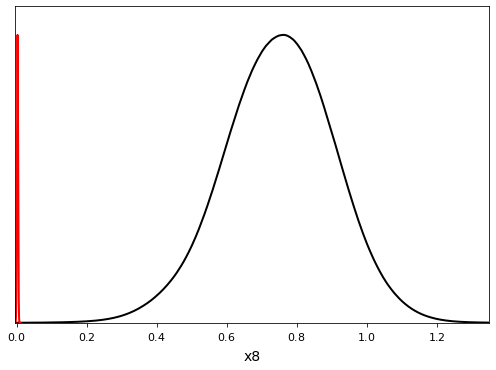

In [87]:
logger.setLevel(logging.INFO)
for j in [0,1,2,3,4,5,6,7,8]:
    samMCMC = MCSamples(samples=samps, names=["x%s"%i for i in [2,3,4,0,1,5,6,7,8,9,10,11,12,13,14,15,16,17,18,
                                                               19]],
                       ranges={'x0':(0.021, None)})#, labels=[str(i) for i in range(6)])
    samMCMC.removeBurnFraction(0.05)
    samSWYFT= MCSamples(samples=sampsSW['params'], names=["x%s"%i for i in range(19)], weights=sampsSW['weights'][(j,)])
    #, weights=np.array([samples['weights'][(0,)]]))
    print(samSWYFT.getInlineLatex('x%s'%j,limit=1),samMCMC.getInlineLatex('x%s'%j,limit=1))
    g = plots.get_single_plotter(width_inch=7)
    g.plot_1d([samSWYFT,samMCMC], 'x%s'%j, normalized=False)
    #plt.axvline(0.02212)
logger.setLevel(logging.DEBUG)

Removed no burn in
Removed no burn in
x0 = 0.02221^{+0.00038}_{-0.00034} x0 = 0.02212^{+0.00040}_{-0.00039}


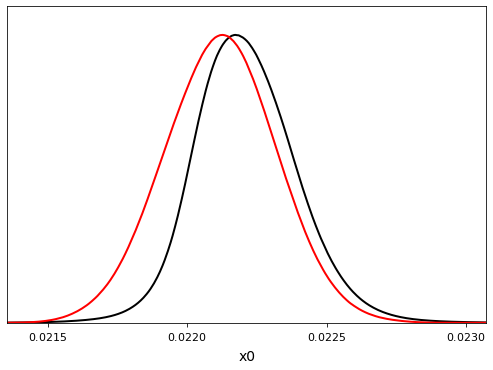

In [84]:
logger.setLevel(logging.INFO)
for j in [0]:
    samMCMC = MCSamples(samples=samps, names=["x%s"%i for i in [2,3,4,0,1,5]],
                       ranges={'x0':(0.021, None)})#, labels=[str(i) for i in range(6)])
    samMCMC.removeBurnFraction(0.05)
    samSWYFT= MCSamples(samples=sampsSW['params'], names=["x%s"%i for i in range(19)], weights=sampsSW['weights'][(j,)])
    #, weights=np.array([samples['weights'][(0,)]]))
    print(samSWYFT.getInlineLatex('x%s'%j,limit=2),samMCMC.getInlineLatex('x%s'%j,limit=2))
    g = plots.get_single_plotter(width_inch=7)
    g.plot_1d([samSWYFT,samMCMC], 'x%s'%j, normalized=False)
logger.setLevel(logging.DEBUG)

In [80]:
obs0={'mu': dat0, 'tau': np.array([0.062])}

Removed no burn in
Removed no burn in
x0 = 0.02220^{+0.00038}_{-0.00034} x0 = 0.02212^{+0.00040}_{-0.00039}
Removed no burn in
Removed no burn in
x1 = 0.1179^{+0.0033}_{-0.0037} x1 = 0.1204^{+0.0039}_{-0.0039}
Removed no burn in
Removed no burn in
x2 = 1.04234^{+0.00078}_{-0.00069} x2 = 1.04172^{+0.00082}_{-0.00082}
Removed no burn in
Removed no burn in
x3 = 3.055^{+0.045}_{-0.044} x3 = 3.044^{+0.030}_{-0.030}
Removed no burn in
Removed no burn in
x4 = 0.9622^{+0.0099}_{-0.0099} x4 = 0.961^{+0.011}_{-0.010}
Removed no burn in
Removed no burn in
x5 = 0.060^{+0.021}_{-0.020} x5 = 0.055^{+0.014}_{-0.014}


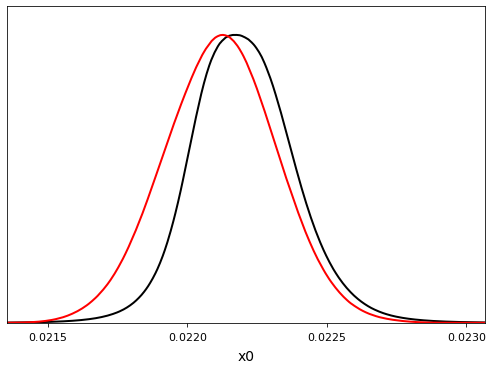

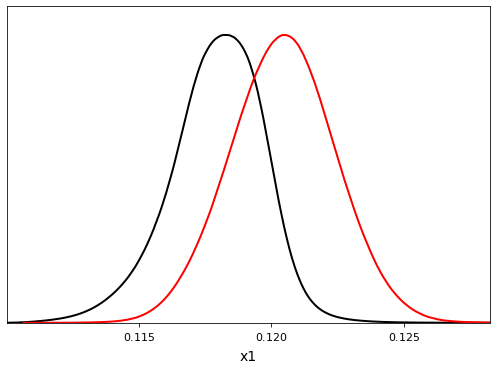

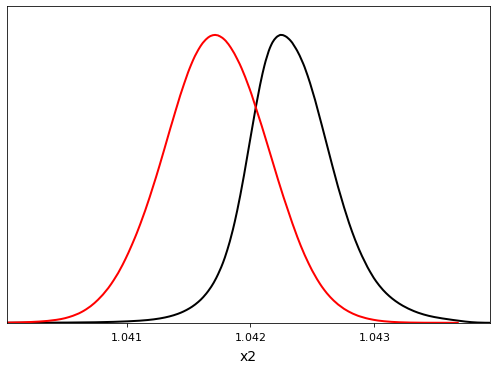

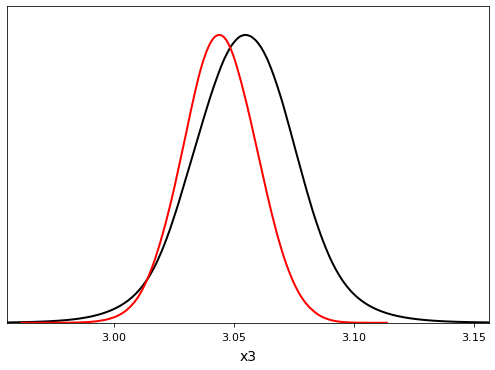

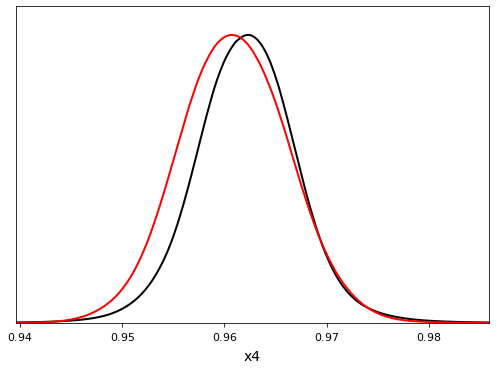

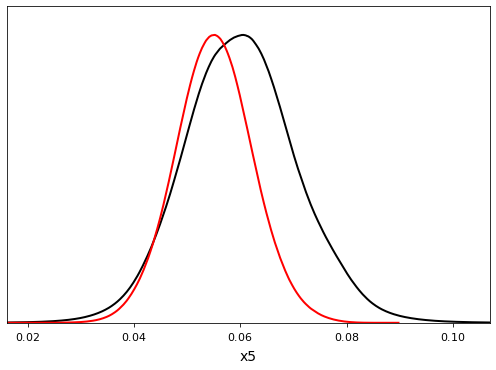

In [81]:
logger.setLevel(logging.INFO)
for j in [0]:
    samMCMC = MCSamples(samples=samps, names=["x%s"%i for i in [2,3,4,0,1,5]],
                       ranges={'x0':(0.021, None)})#, labels=[str(i) for i in range(6)])
    samMCMC.removeBurnFraction(0.05)
    samSWYFT= MCSamples(samples=sampsSW['params'], names=["x%s"%i for i in range(19)], weights=sampsSW['weights'][(j,)])
    #, weights=np.array([samples['weights'][(0,)]]))
    print(samSWYFT.getInlineLatex('x%s'%j,limit=2),samMCMC.getInlineLatex('x%s'%j,limit=2))
    g = plots.get_single_plotter(width_inch=7)
    g.plot_1d([samSWYFT,samMCMC], 'x%s'%j, normalized=False)
logger.setLevel(logging.DEBUG)

In [ ]:
array([ 2.1070000e-02,  1.1040000e-01,  1.0394900e+00,  2.9480000e+00,
        9.3590000e-01,  7.0011000e-03,  6.0002000e-01, -1.9998000e-01,
        2.0000000e-05,  2.0000000e-05,  2.0000000e-05,  0.0000000e+00,
        0.0000000e+00,  9.8750025e-01, -9.9998000e-03, -9.9998000e-03,
       -9.9998000e-03, -9.9998000e-03, -9.9998000e-03])

array([2.31700000e-02, 1.31400000e-01, 1.04379000e+00, 3.16800000e+00,
       9.93900000e-01, 1.16998900e-01, 2.59998000e+00, 1.79998000e+00,
       1.99998000e+00, 1.99998000e+00, 1.99998000e+00, 1.00000000e+01,
       1.00000000e+01, 1.01249975e+00, 9.99980000e-03, 9.99980000e-03,
       9.99980000e-03, 9.99980000e-03, 9.99980000e-03])

DEBUG:root:x3 1D sigma_range, std: 0.01607940896091508, 0.030229695383903646; smooth_1D_bins: 21.801391596562265 


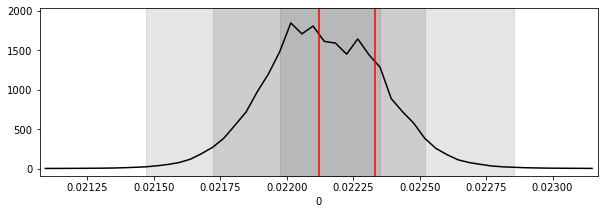

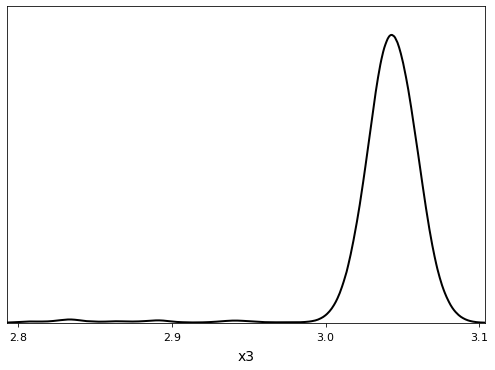

In [180]:
for i in [0]:
    swyft.plot1d(samples, [i],figsize=(10,3),bins=50)
    plt.axvline(valPaper[i],color='red')
    plt.axvline(valPaper[i]+sigPaper[i],color='red')
    plt.axvline(0.058,color='pink')
    g = plots.get_single_plotter(width_inch=7)
    g.plot_1d(samMCMC, 'x3')

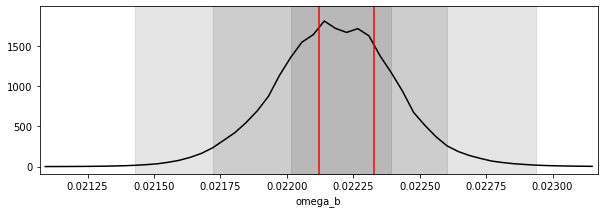

In [217]:
for i in [0]:
    swyft.plot1d(samples, [i],figsize=(10,3),bins=50, labels=[labels[i]])
    plt.axvline(valPaper[i],color='red')
    plt.axvline(valPaper[i]+sigPaper[i],color='red')
    plt.axvline(0.058,color='pink')

In [240]:
post.infer([1], device = 'cuda', head = Head10,
          train_args={'lr_schedule':[1e-3,3e-4],'early_stopping_patience':2,
                     'max_epochs': 50})

DEBUG:root:Initializing swyft.Module with tag `Head10`
DEBUG:root:  args = `()`
DEBUG:root:  kwargs = `{'obs_shapes': {'mu': torch.Size([10816]), 'tau': torch.Size([1])}}`
DEBUG:root:Initializing swyft.Module with tag `DefaultTail`
DEBUG:root:  args = `(101, [(1,)])`
DEBUG:root:  kwargs = `{'n_tail_features': 2, 'p': 0.0, 'hidden_layers': [256, 256, 256], 'online_norm': True, 'param_transform': None, 'tail_features': False}`
DEBUG:root:Entering trainloop
DEBUG:root:  combinations = None
DEBUG:root:  batch_size = 32
DEBUG:root:  nworkers = 0
DEBUG:root:  max_epochs = 50
DEBUG:root:  early_stopping_patience = 2
DEBUG:root:  lr_schedule = [0.001, 0.0003]
DEBUG:root:  percent_validation = 0
DEBUG:root:lr: 0.001
DEBUG:root:validation loss = 1.339
DEBUG:root:validation loss = 1.374
DEBUG:root:validation loss = 1.376
DEBUG:root:lr: 0.0003
DEBUG:root:validation loss = 1.085
DEBUG:root:validation loss = 0.9585
DEBUG:root:validation loss = 0.9242
DEBUG:root:validation loss = 0.9524
DEBUG:root:va

In [241]:
samples=post.sample(100000,obs0)

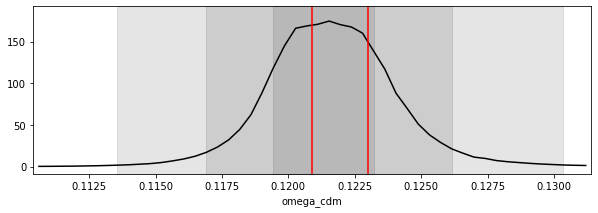

In [242]:
for i in [1]:
    swyft.plot1d(samples, [i],figsize=(10,3),bins=50, labels=[labels[i]])
    plt.axvline(valPaper[i],color='red')
    plt.axvline(valPaper[i]+sigPaper[i],color='red')

In [ ]:
from swyft.networks import OnlineNormalizationLayer
class Head10(swyft.Module):
    def __init__(self, obs_shapes):
        super().__init__(obs_shapes=obs_shapes)

        self.n_features = 101
        self.l = torch.nn.Linear(10816, 100)
        self.onl_f = OnlineNormalizationLayer(torch.Size([10816]))
        self.onl_f2=OnlineNormalizationLayer(torch.Size([1]))

    def forward(self, obs):
        x = obs['mu']
        t = obs['tau']
        x=self.onl_f(x)
        t=self.onl_f2(t)
        
        x=self.l(x)
        return torch.cat((t,x),axis=1)

In [ ]:
post.infer([2], device = 'cuda', head = Head10,
          train_args={'lr_schedule':[1e-3,3e-4],'early_stopping_patience':2,
                     'max_epochs': 50})

DEBUG:root:Initializing swyft.Module with tag `Head10`
DEBUG:root:  args = `()`
DEBUG:root:  kwargs = `{'obs_shapes': {'mu': torch.Size([10816]), 'tau': torch.Size([1])}}`
DEBUG:root:Initializing swyft.Module with tag `DefaultTail`
DEBUG:root:  args = `(101, [(2,)])`
DEBUG:root:  kwargs = `{'n_tail_features': 2, 'p': 0.0, 'hidden_layers': [256, 256, 256], 'online_norm': True, 'param_transform': None, 'tail_features': False}`
DEBUG:root:Entering trainloop
DEBUG:root:  combinations = None
DEBUG:root:  batch_size = 32
DEBUG:root:  nworkers = 0
DEBUG:root:  max_epochs = 50
DEBUG:root:  early_stopping_patience = 2
DEBUG:root:  lr_schedule = [0.001, 0.0003]
DEBUG:root:  percent_validation = 0
DEBUG:root:lr: 0.001
DEBUG:root:validation loss = 1.386
DEBUG:root:validation loss = 1.386
DEBUG:root:validation loss = 1.386


In [244]:
samples=post.sample(100000,obs0)

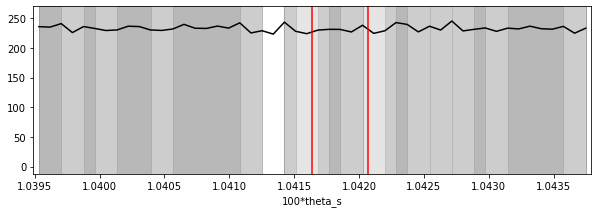

In [245]:
for i in [2]:
    swyft.plot1d(samples, [i],figsize=(10,3),bins=50, labels=[labels[i]])
    plt.axvline(valPaper[i],color='red')
    plt.axvline(valPaper[i]+sigPaper[i],color='red')

0.00923109504369659


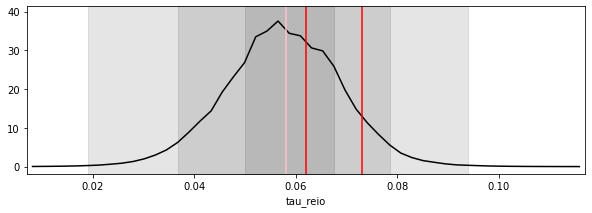

In [192]:
for i in [5]:
    swyft.plot1d(samples, [i],figsize=(10,3),bins=50, labels=[labels[i]])
    plt.axvline(valPaper[i],color='red')
    plt.axvline(valPaper[i]+sigPaper[i],color='red')
    plt.axvline(0.058,color='pink')
    weights_key = tuple([i])
    w = samples["weights"][tuple(weights_key)]
    x = samples1["params"][:, i]
    v, e = np.histogram(x, weights=w, bins=100, density=True)
    zm = (e[1:] + e[:-1]) / 2
    levels = sorted(swyft.utils.plot.get_contour_levels(v))
    sig1=(0.5*(e[np.where(v>levels[2])][-1]-e[np.where(v>levels[2])][0]))
    print(sig1)